<font color = 'blue'>
Content: 


1. [Load Python Pakages](#1)
2. [First look to data](#2)
3. [Exploratory Data Analysis](#3)   
4. [Feature Engineering (Later)](#6)
    * [A custom pipeline for Feature Engineering](#7)
5. [Preprocesing](#8)  
6. [Modeling and hyperparameter tuning](#9)
    * [XGBoost](#10)
    * [Lightgbm](#11)
    * [Catboost](#12)
    * [Neural Net (Keras with scikit_learn wrapper)](#13)
8. [Performance Summary](#14)
9. [Voting vs Stacking and selection](#15)
10. [Submission](#18)
11. [Appendix (Optuna settings)](#19)



<a id = "1"></a><br>
# Load Python Pakages


In [2]:
pip install optuna

                                              0.0/380.1 kB ? eta -:--:--
     ---------                               92.2/380.1 kB 1.7 MB/s eta 0:00:01
     -------------------                    194.6/380.1 kB 1.7 MB/s eta 0:00:01
     ------------------------               245.8/380.1 kB 1.5 MB/s eta 0:00:01
     -------------------------------------  378.9/380.1 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 380.1/380.1 kB 1.4 MB/s eta 0:00:00
                                              0.0/233.4 kB ? eta -:--:--
     ------------------                     112.6/233.4 kB 3.3 MB/s eta 0:00:01
     -----------------------                143.4/233.4 kB 2.1 MB/s eta 0:00:01
     ------------------------------------   225.3/233.4 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 233.4/233.4 kB 1.4 MB/s eta 0:00:00
                                              0.0/78.6 kB ? eta -:--:--
     ---------------------------------------- 78.6/78.6 kB 2.2

In [1]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


#preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, LabelEncoder


#statistics
from scipy import stats
from scipy.stats import randint, mode


#feature engineering
from sklearn.feature_selection import mutual_info_classif


#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config


#algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression # Don't use it. (This is a multiclass classification problem)
from sklearn.svm import SVC


#model evaluation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice



#for algorithm run time comparison
import time

#define a random_state for reproducibility
random_state = 42

ModuleNotFoundError: No module named 'optuna'

<a id = "2"></a><br>
#  First look to data

In [2]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col=[0])
original_df = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
original_df.index.names = ['id']

# reserve a clean copy for modelling
pipe_data = train_df.copy()
pipe_test = test_df.copy()
pipe_original = original_df.copy()

train_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


<a id = "3"></a><br>
# Exploratory Data Analysis

<a id = "4"></a><br>
## Descpriptive statistics 

In [3]:
#descriptive statistics
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000
Father's qualification,76518.0,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,44.000


<a id = "5"></a><br>

## Grouping features for preprocessing purposes

In [4]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Target"]

binary_features = ['Scholarship holder','International','Gender','Tuition fees up to date','Daytime/evening attendance','Debtor','Educational special needs','Displaced']

target = "Target"

#categorical_features = []

continuous_features = list(set(feature_list) - set(binary_features))

assert feature_list.sort() == (continuous_features + binary_features).sort()

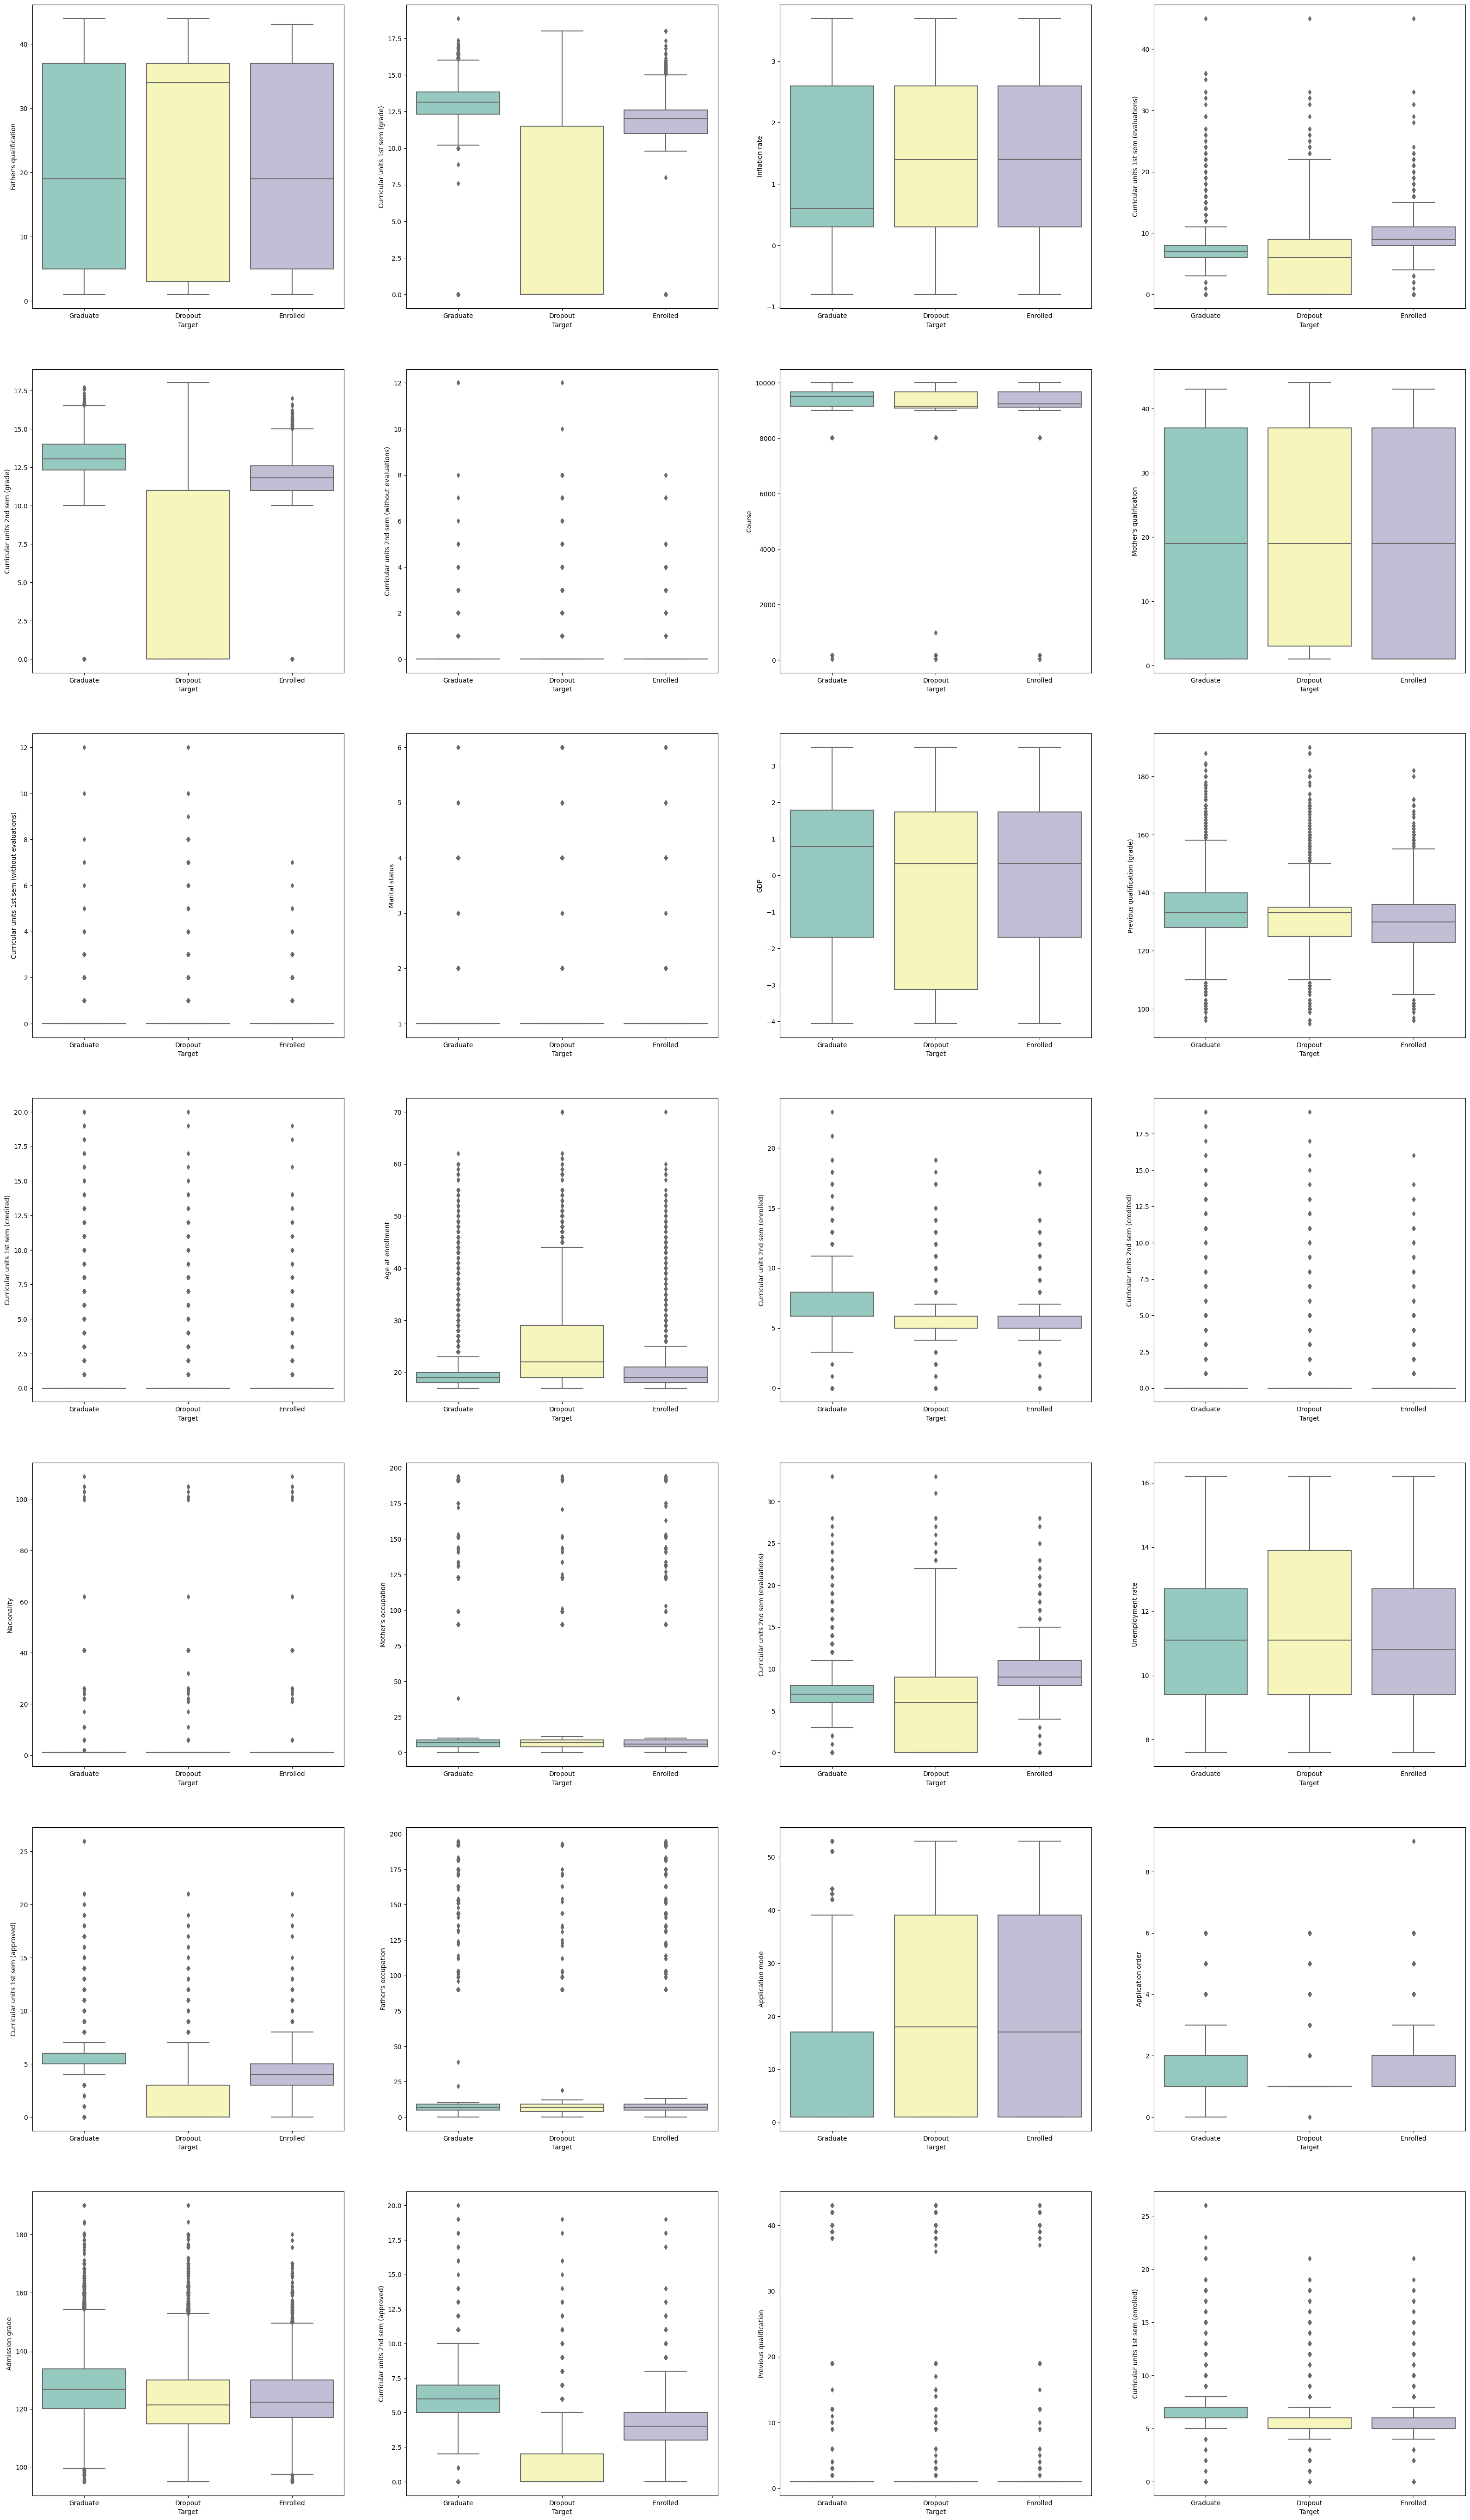

In [5]:
fig, ax = plt.subplots(7, 4, figsize=(40, 70))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Target', y=var, data=train_df, ax=subplot, palette='Set3')

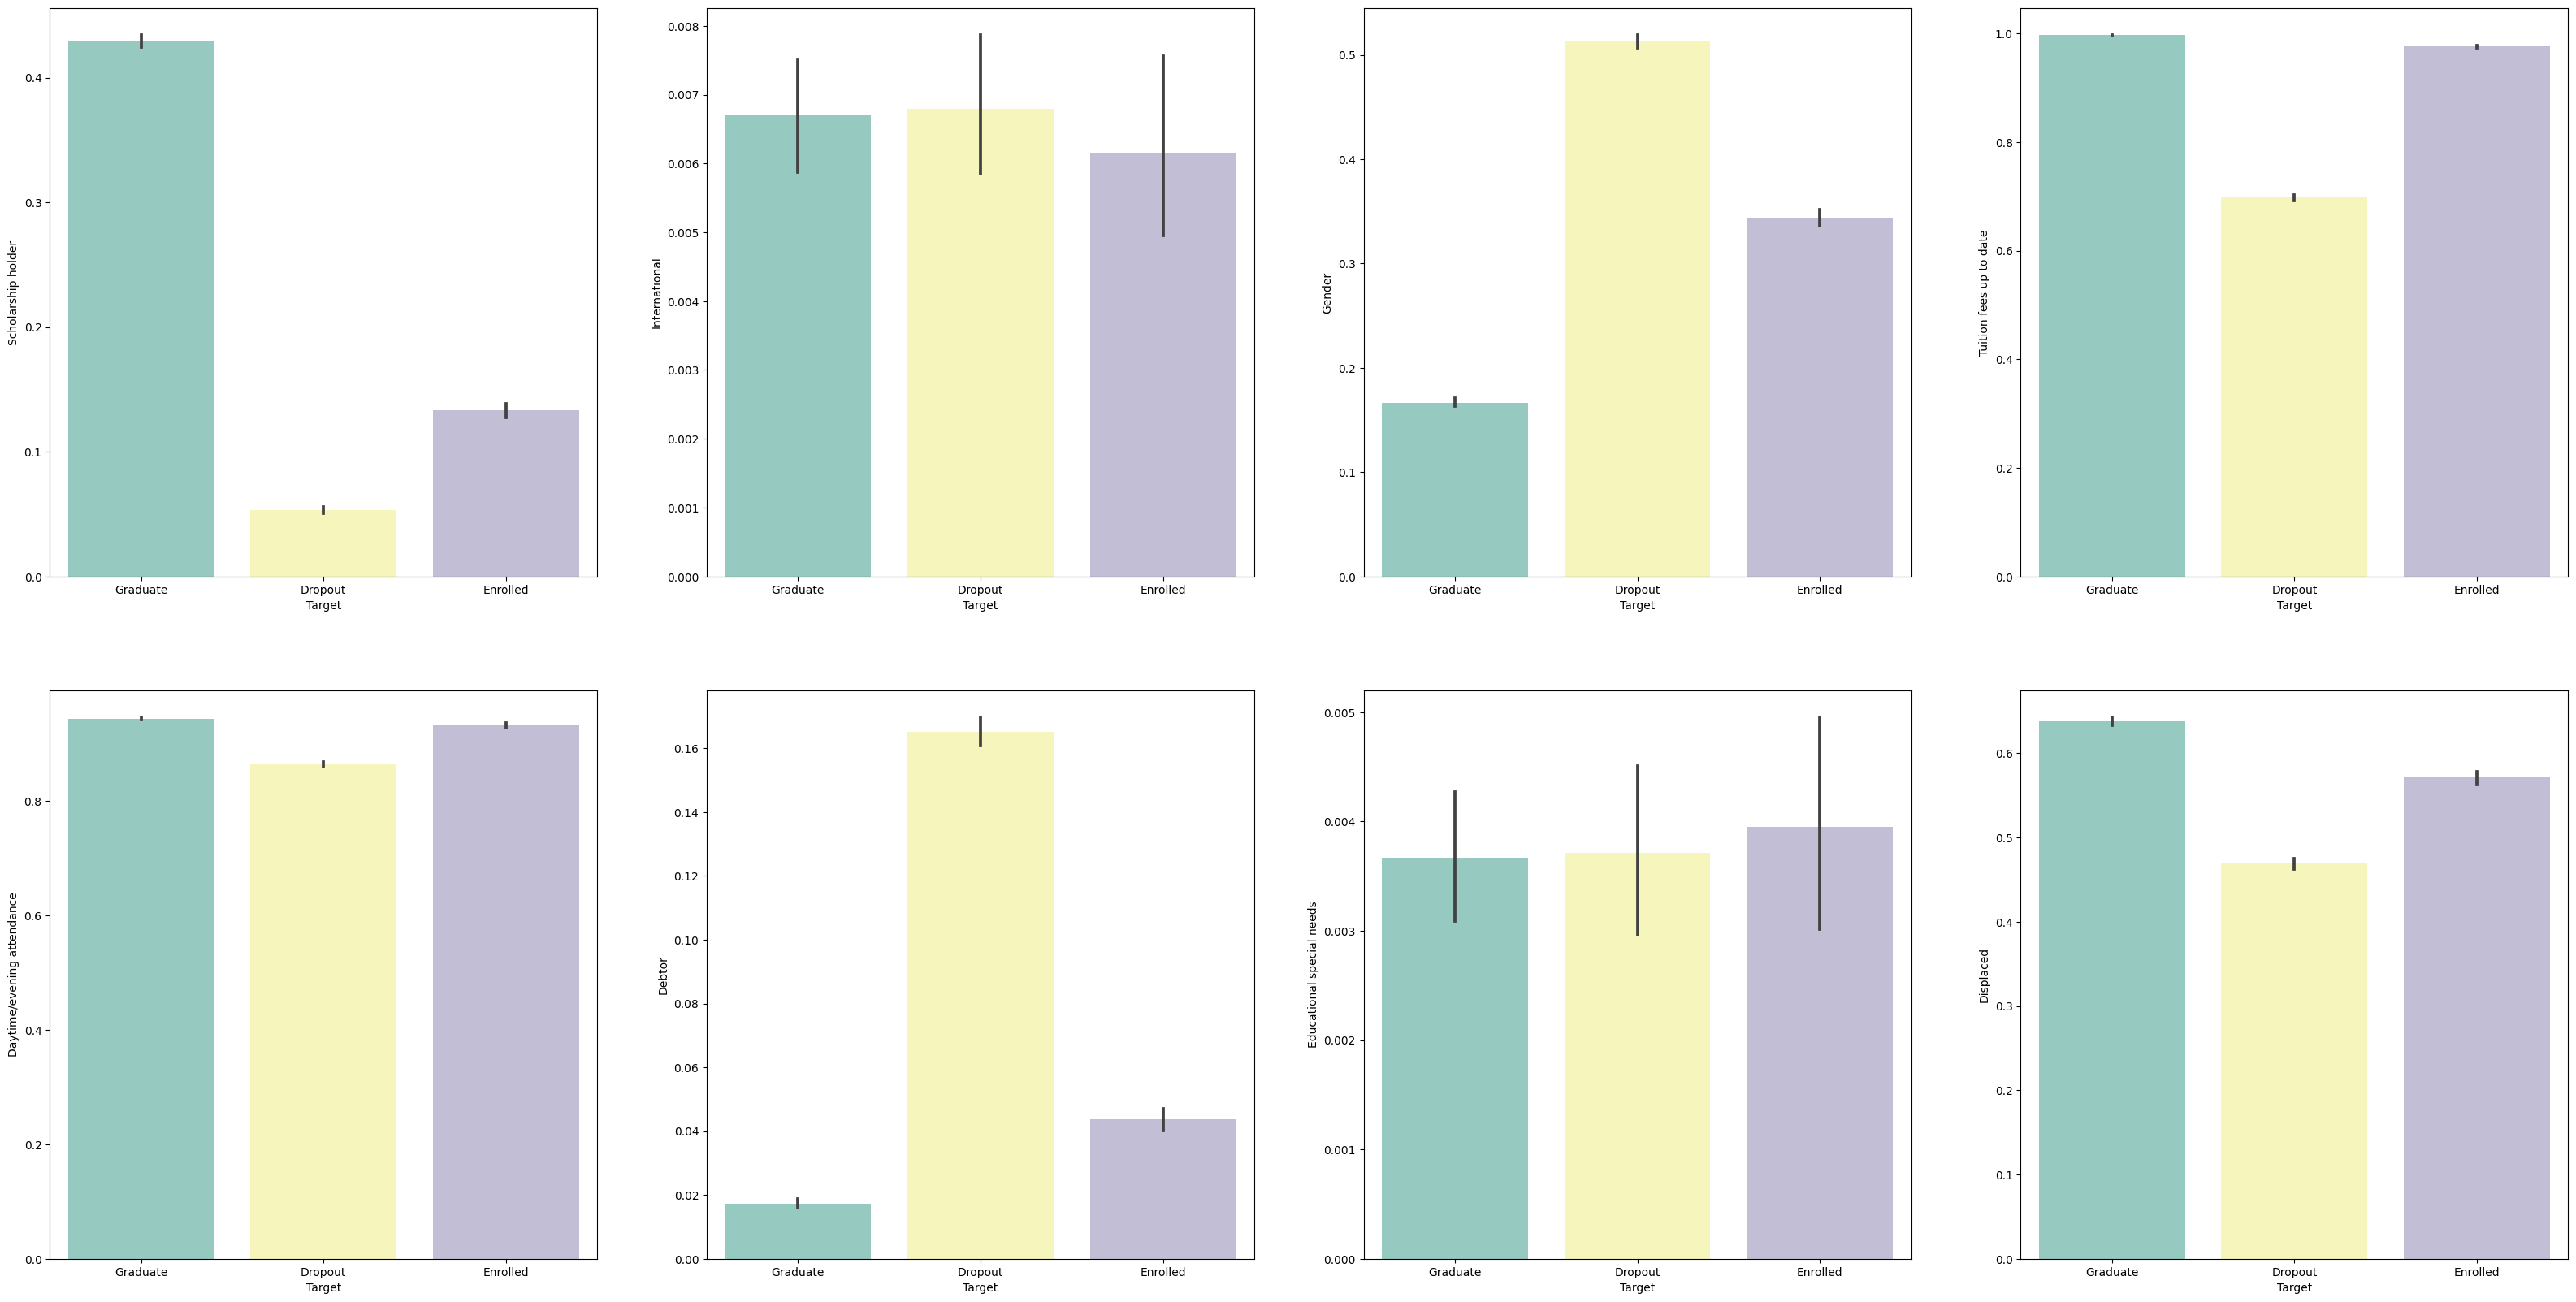

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(40, 20))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x='Target', y= var, data=train_df, ax=subplot, palette='Set3')

## Target Distribution

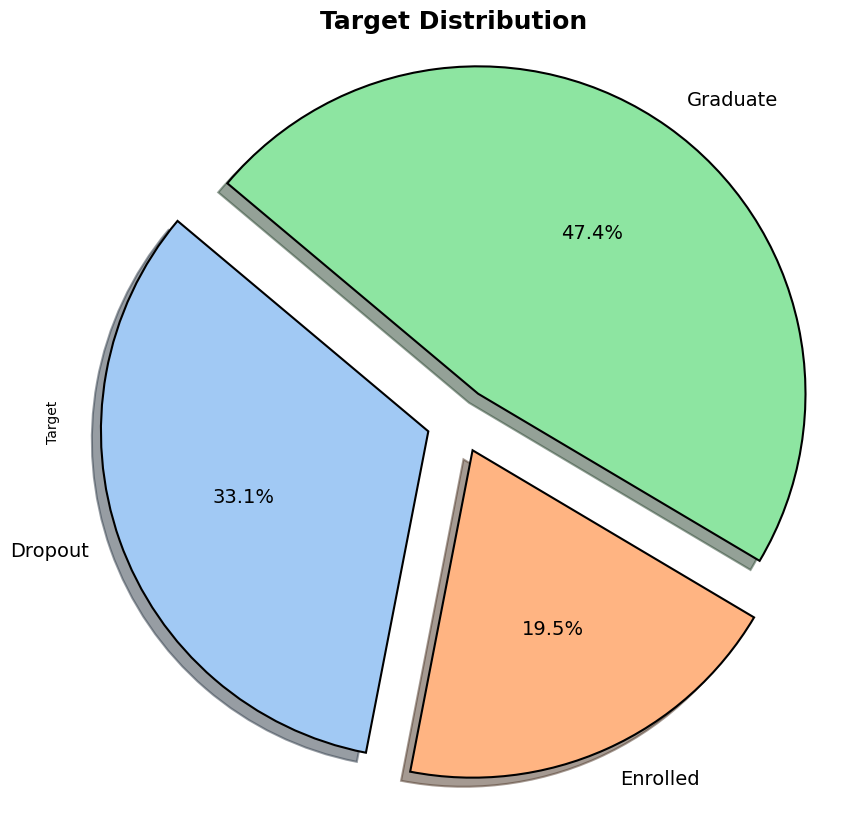

In [7]:
plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.1 for _ in range(train_df['Target'].nunique())]

# Plotting
train_df.groupby('Target')['Target'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

In [8]:
# Mutual Information score
y_sampled = train_df.Target
mutual_df = train_df[feature_list ]

mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Curricular units 2nd sem (approved),0.480612
Curricular units 2nd sem (grade),0.415702
Curricular units 1st sem (approved),0.406072
Curricular units 1st sem (grade),0.365919
Curricular units 2nd sem (evaluations),0.198004
Curricular units 1st sem (evaluations),0.190375
Course,0.118762
Tuition fees up to date,0.108057
Admission grade,0.107321
Age at enrollment,0.095786


Mutual information scores for some features are pretty low. Feature selection may be usefull. 


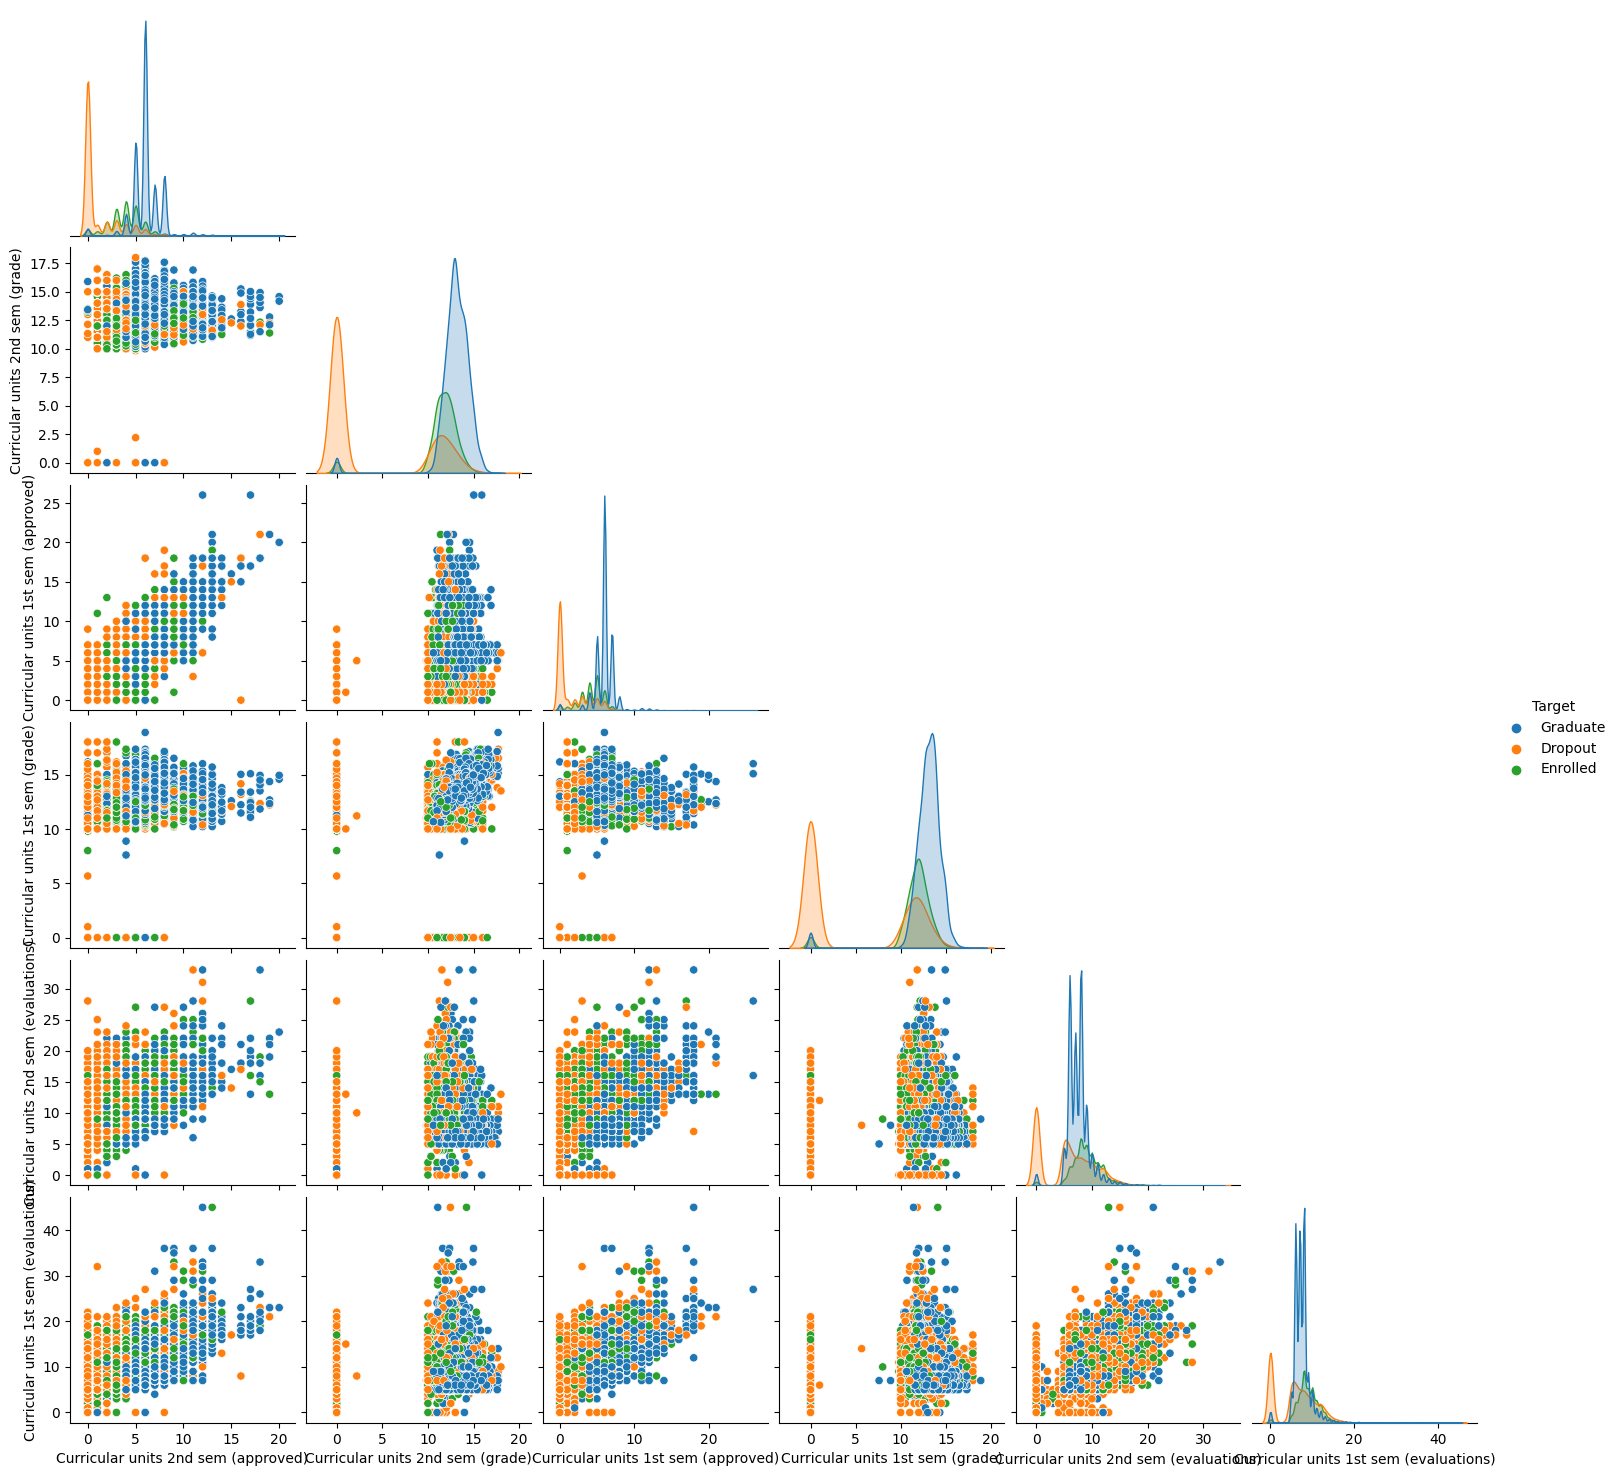

In [9]:
#Pair-plot for most important features
most_important_features = mutual_info[mutual_info['Numerical_Feature_MI'] > 0.15].index.tolist()
sns.pairplot(train_df[most_important_features + ["Target"]], hue="Target",  corner=True)

<a id = "6"></a><br>
# Feature Engineering

<a id = "7"></a><br>
# A custom pipeline for Feature Engineering

later...

<a id = "8"></a><br>
# Preprocessing

In [10]:
# Preprocessing object for neural net
nn_preprocessor = MinMaxScaler()

In [11]:
# No processing is applied for boosting models

In [12]:
#Just simple target encoding
label_encoder = LabelEncoder()
pipe_data['Target'] = label_encoder.fit_transform(pipe_data['Target'])
pipe_original['Target'] = label_encoder.transform(pipe_original['Target'])

<a id = "9"></a><br>
# Modeling

Hyperparameter optimization is performed with Optuna. You can find Optuna settings for different models in the Appendix.

In [13]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

In [14]:
def cross_validate_score(model, data, cv=cv, test_data=pipe_test, label='Target', include_original=True):
    X = data.copy()
    y = X.pop(label)
    
    # Initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X), 3))  # Adjust for class probabilities
    train_scores, val_scores = [], []
    
    # Training model and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Define train set
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        # Define validation set
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            X_train = pd.concat([pipe_original.drop(label, axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([pipe_original[label], y_train]).reset_index(drop=True)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_preds = model.predict(X_train)
        val_preds_proba = model.predict_proba(X_val)  # Get class probabilities
        
        # Store validation predictions
        val_predictions[val_idx] = val_preds_proba
        
        # Evaluate model for a fold
        val_preds = np.argmax(val_preds_proba, axis=1)  # Get predicted classes for accuracy score
        train_score = accuracy_score(y_train, train_preds)
        val_score = accuracy_score(y_val, val_preds)
        
        print(f'Fold {fold}: {val_score:.5f}')
        
        # Append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    # Refit the model on the entire dataset, including the original data
    if include_original:
        X_full = pd.concat([pipe_original.drop(label, axis=1), X]).reset_index(drop=True)
        y_full = pd.concat([pipe_original[label], y]).reset_index(drop=True)
    else:
        X_full = X
        y_full = y
    
    model.fit(X_full, y_full)
    
    # Make final predictions on the test set
    test_predictions_proba = model.predict_proba(test_data)  # Get class probabilities
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions_proba

In [15]:
cv_summary, oof_predictions_df, submission_predictions_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

<a id = "10"></a><br>
## XGboost

In [16]:
xgb_optuna_params = {
    'n_estimators': 929,
    'alpha': 2.287466581490129e-05,
    'subsample': 0.8766675651018592,
    'colsample_bytree': 0.288332829334817,
    'max_depth': 8,
    'min_child_weight': 6,
    'learning_rate': 0.024083411832750343,
    'gamma': 0.001816649055813574
}




xgb_tuned = XGBClassifier(**xgb_optuna_params, random_state=random_state)

In [17]:
%%time
cv_summary['xgb'], oof_predictions_df[['xgb_0', 'xgb_1', 'xgb_2']], submission_predictions_df[['xgb_0', 'xgb_1', 'xgb_2']] = cross_validate_score(xgb_tuned, data=pipe_data, include_original=True)



Fold 0: 0.83782
Fold 1: 0.83632
Fold 2: 0.83383
Fold 3: 0.83265
Fold 4: 0.83480
Val Score: 0.8350845 ± 0.0018213 | Train Score: 0.8900552 ± 0.0002915 | Target
CPU times: user 15min 13s, sys: 3.23 s, total: 15min 16s
Wall time: 3min 55s


<a id = "11"></a><br>
## Lightgbm

In [18]:
lgbm_optuna_params = {
    'n_estimators': 1894,
    'max_depth': 23,
    'learning_rate': 0.024309983270196903,
    'min_data_in_leaf': 27,
    'subsample': 0.40065361124232945,
    'max_bin': 267,
    'feature_fraction': 0.1326832138080814
}


lgbm_tuned = LGBMClassifier(**lgbm_optuna_params, random_state=random_state, verbose=-1)


In [19]:
%%time
cv_summary['lgbm'], oof_predictions_df[['lgbm_0', 'lgbm_1','lgbm_2']], submission_predictions_df[['lgbm_0', 'lgbm_1','lgbm_2']] = cross_validate_score(lgbm_tuned, data = pipe_data, include_original=True)

Fold 0: 0.83743
Fold 1: 0.83579
Fold 2: 0.83410
Fold 3: 0.83232
Fold 4: 0.83650
Val Score: 0.8352283 ± 0.0018178 | Train Score: 0.8730743 ± 0.0004690 | Target
CPU times: user 10min 47s, sys: 11.4 s, total: 10min 58s
Wall time: 10min 29s


<a id = "12"></a><br>
## Catboost

In [20]:
catb_optuna_params = {
    
    'colsample_bylevel': 0.6383474716497279,
    'learning_rate': 0.09475494290429642,
    'random_strength': 0.07771221926568195,
    'max_bin': 490,
    'depth': 5,
    'l2_leaf_reg': 5,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8429457747642737
    
}



catb_tuned = CatBoostClassifier(**catb_optuna_params, random_state=random_state, logging_level='Silent')


In [21]:
%%time
cv_summary['catb'], oof_predictions_df[['catb_0', 'catb_1','catb_2']], submission_predictions_df[['catb_0', 'catb_1','catb_2']] = cross_validate_score(catb_tuned, data = pipe_data, include_original=True)

Fold 0: 0.83481
Fold 1: 0.83396
Fold 2: 0.83214
Fold 3: 0.82905
Fold 4: 0.83526
Val Score: 0.8330458 ± 0.0022650 | Train Score: 0.8502066 ± 0.0006551 | Target
CPU times: user 11min 11s, sys: 22.4 s, total: 11min 33s
Wall time: 3min 11s


<a id = "13"></a><br>
## Neural Net (Keras with scikit_learn wrapper)

In [22]:
!pip install --no-deps scikeras

In [23]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv1D
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
import tensorflow.keras.backend as K

tf.keras.utils.set_random_seed(random_state)
tf.config.experimental.enable_op_determinism()

2024-06-06 02:17:04.407198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 02:17:04.407427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 02:17:04.582788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
from scikeras.wrappers import KerasClassifier

def get_model():
    inputs = keras.Input(shape=(36,))

    # Define the hidden layers
    x = keras.layers.Dense(64, activation='leaky_relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)

    concatenated = keras.layers.Concatenate()([x, inputs])

    y = keras.layers.Dense(128, activation='leaky_relu')(concatenated)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.2)(y)

    concatenated = keras.layers.Concatenate()([y, concatenated])

    z = keras.layers.Dense(128, activation='leaky_relu')(concatenated)
    z = keras.layers.BatchNormalization()(z)
    z = keras.layers.Dropout(0.2)(z)

    concatenated = keras.layers.Concatenate()([z, concatenated])

    t = keras.layers.Dense(64, activation='leaky_relu')(concatenated)
    t = keras.layers.BatchNormalization()(t)
    t = keras.layers.Dropout(0.2)(t)

    # Define the output layer
    outputs = keras.layers.Dense(units=3, activation='softmax')(t)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the KerasClassifier
nn_classifier = KerasClassifier(
    get_model,
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    epochs =100,
    random_state=random_state,     
    batch_size=1024, 
    validation_split = 0.2,
    verbose=0,
    
    callbacks=[keras.callbacks.ReduceLROnPlateau, keras.callbacks.EarlyStopping], #, keras.callbacks.ModelCheckpoint]
    callbacks__0__monitor="val_loss",  
    callbacks__0__factor=0.5,  
    callbacks__0__verbose=0,  
    callbacks__0__min_delta=0.0001,  
    callbacks__0__patience=5,  
    callbacks__0__min_lr=0.0000001,  
    callbacks__1__min_delta=0.0001,  
    callbacks__1__patience=8, 
    callbacks__1__restore_best_weights=True,  

    #callbacks__2__filepath="training_1/cp.keras",  
    #callbacks__2__monitor="val_loss",  
    #callbacks__2__mode="min",  
    #callbacks__2__verbose=1,  
    #callbacks__2__save_best_only=True,   

)

In [25]:
nn_pipeline = Pipeline([
    #('FeatureEngineer', FeatureEngineer),
    ('nn_preprocessor', nn_preprocessor),
    ('nn_classifier', nn_classifier),
])

nn_pipeline

Pipeline(steps=[('nn_preprocessor', MinMaxScaler()),
                ('nn_classifier',
                 KerasClassifier(batch_size=1024, callbacks=[<class 'keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau'>, <class 'keras.src.callbacks.early_stopping.EarlyStopping'>], callbacks__0__factor=0.5, callbacks__0__min_delta=0.0001, callbacks__0__min_lr=1e-07, callbacks__0__monitor='val_loss', callbacks__0__patience=5, callbacks__0__verbose=0, callbacks__1__min_delta=0.0001, callbacks__1__patience=8, callbacks__1__restore_best_weights=True, epochs=100, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function get_model at 0x79d07560df30>, optimizer='adam', random_state=42, validation_split=0.2, verbose=0))])

In [26]:
%%time
cv_summary['nn'], oof_predictions_df[['nn_0', 'nn_1','nn_2']], submission_predictions_df[['nn_0', 'nn_1','nn_2']] = cross_validate_score(nn_pipeline, data = pipe_data, include_original=False)


Fold 0: 0.82410
Fold 1: 0.82344
Fold 2: 0.82351
Fold 3: 0.81912
Fold 4: 0.82369
Val Score: 0.8227737 ± 0.0018408 | Train Score: 0.8278346 ± 0.0012114 | Target
CPU times: user 7min 53s, sys: 2.31 s, total: 7min 55s
Wall time: 10min 18s


<a id = "14"></a><br>
## Performance Summary

In [27]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold-1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold-1,fold2,fold3,fold4,fold5,Mean,Std
lgbm,0.837428,0.835795,0.834096,0.832320,0.836503,0.835228,0.001818
xgb,0.837820,0.836317,0.833834,0.832647,0.834804,0.835085,0.001821
catb,0.834814,0.833965,0.832135,0.829053,0.835261,0.833046,0.002265
nn,0.824098,0.823445,0.823510,0.819120,0.823695,0.822774,0.001841


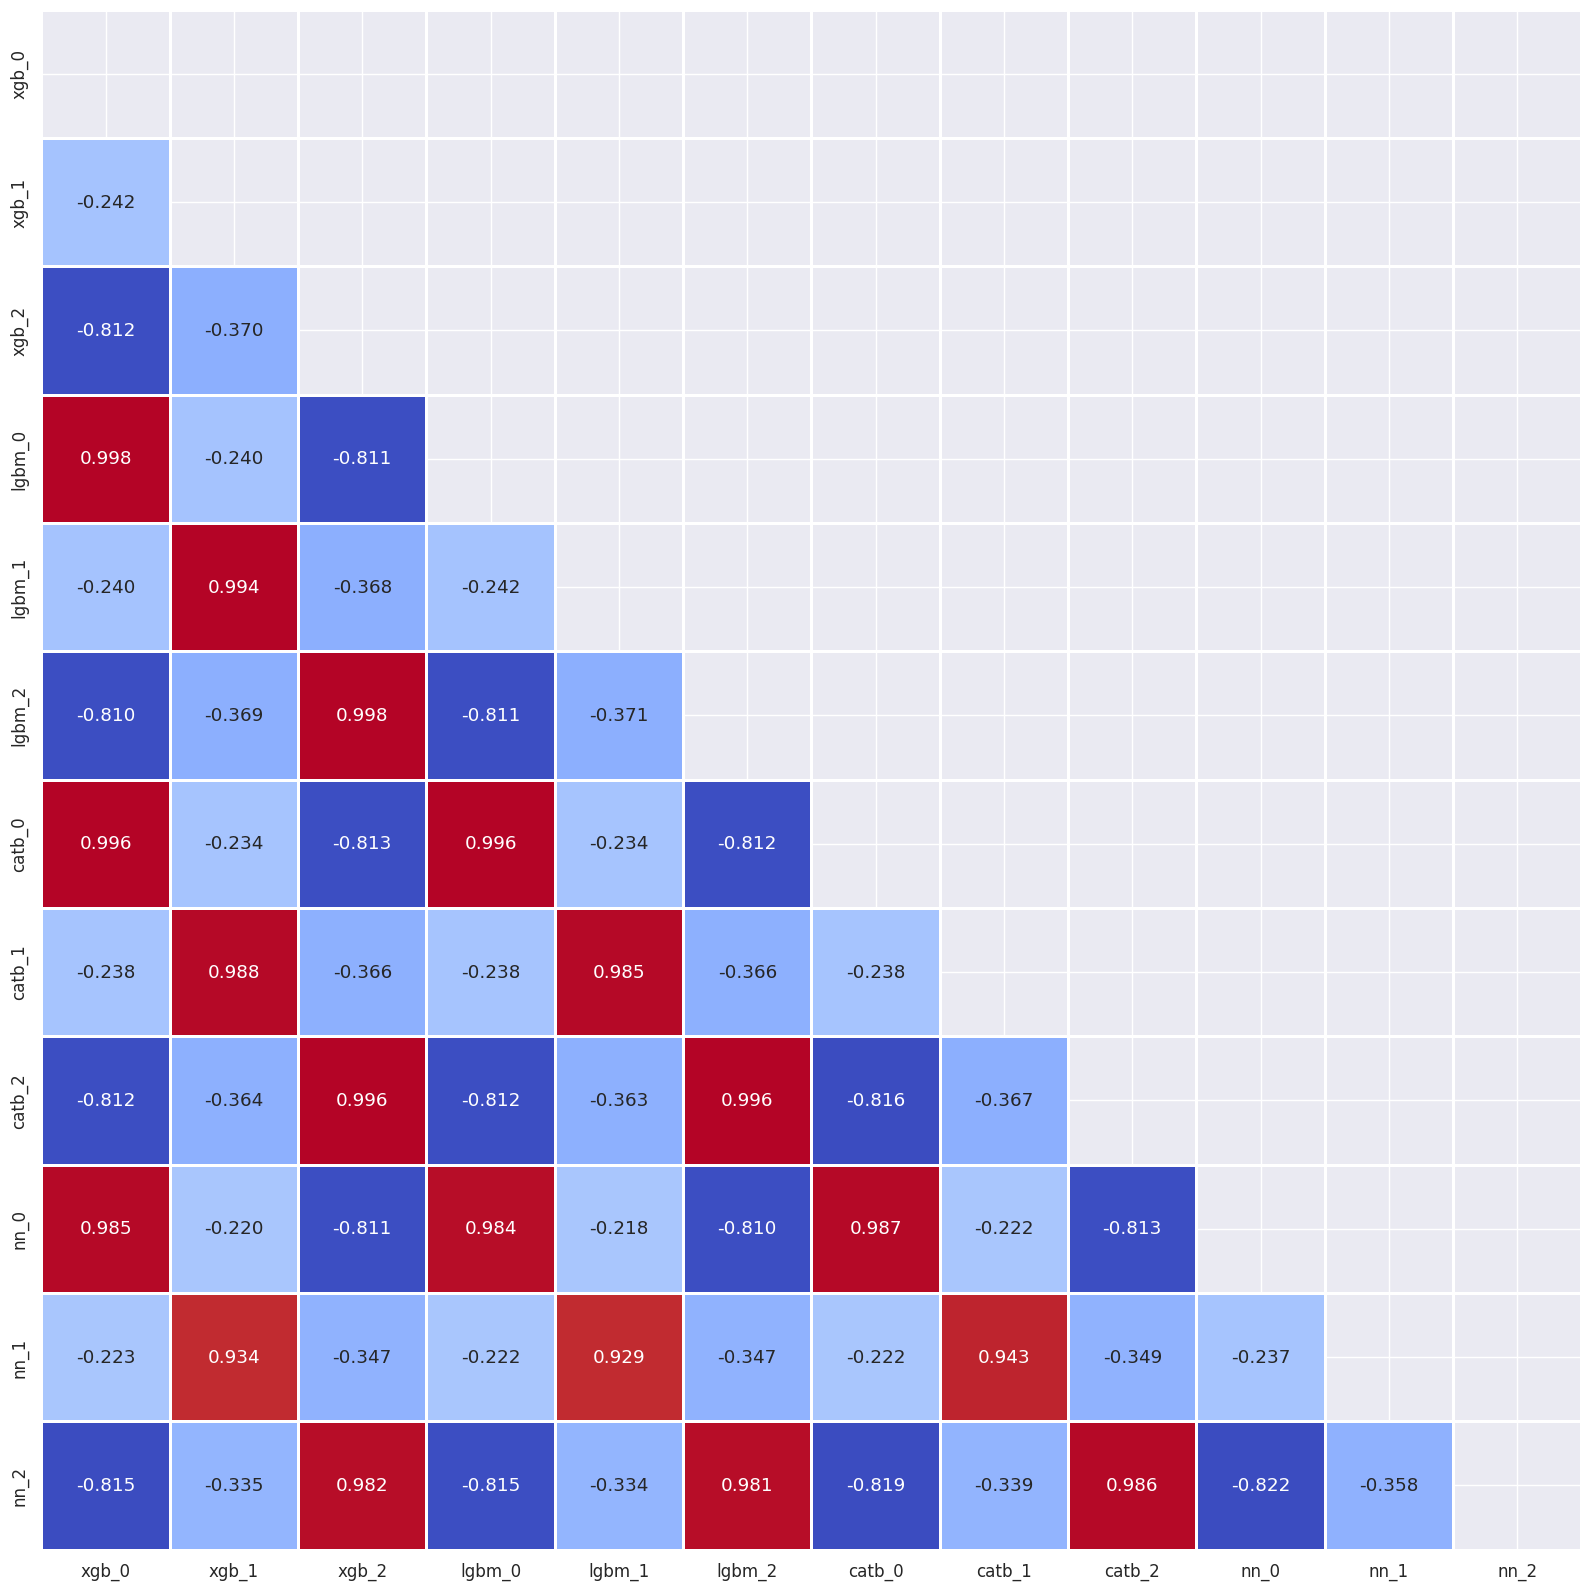

In [28]:
# Model diversity check

sns.set(font_scale=1.1)
correlation_train = oof_predictions_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

<a id = "15"></a><br>
## Voting vs Stacking and selection

<a id = "16"></a><br>
## Voting

In [29]:
def hard_voting_ensemble(oof_predictions_df, y_actual):
    # Sum the probabilities for each class across all models
    class_probabilities = np.zeros((len(oof_predictions_df), 3))
    
    for model in ['xgb', 'lgbm', 'catb', 'nn']:  # Replace with actual model names
        class_probabilities += oof_predictions_df[[f'{model}_0', f'{model}_1', f'{model}_2']].values
    
    # Get the final class predictions based on the highest probability
    final_predictions = np.argmax(class_probabilities, axis=1)
    
    voting_accuracy = accuracy_score(final_predictions, y_actual)
    
    print(f'Ensemble Accuracy: {voting_accuracy:.5f}')
    
    return voting_accuracy

In [30]:
hard_voting_ensemble(oof_predictions_df, pipe_data.Target)

Ensemble Accuracy: 0.83397


0.8339737055333386

<a id = "17"></a><br>
## Stacking 

I tried logistic regression as meta classifier but it did not performed well. Then I change it to XGBoost. Following optuna code tunes XGBClassifier using oof_predictions_df and Target.

Some insights why logistic regression did not work: 

- Logistic regression was originaly designed for binary classification problems. For multi-class it uses  ‘ovr’, ‘multinomial’ strategies. But this strategies did not work well for this problem. 

- For other possible reasons see discussion on this link:  https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2853531

In [31]:
#def objective(trial):

    # L1 regularization weight.
#    n_estimators = trial.suggest_int("n_estimators", 10, 100)

#    alpha1 = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.2, 0.9)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.2, 0.9)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 16)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 8)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-2, 0.5, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#    include_original = trial.suggest_categorical('include_original', [True, False])


#    xgb_regressor = XGBClassifier(n_estimators = n_estimators, alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,
#                           random_state =random_state)
    

    
#    ss = cv
#    score = cross_val_score(xgb_regressor, oof_predictions_df, pipe_data.Target, scoring= 'accuracy',  cv=ss)
#    score = score.mean()
#    return score


#sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)



In [32]:
#parameters suggested for meta model                                                                                                 
meta_model_params = {
    'n_estimators': 55, 
    'alpha': 0.0715048208895447,
    'subsample': 0.7351079856533367, 
    'colsample_bytree': 0.6494126884499368, 
    'max_depth': 4, 
    'min_child_weight': 7, 
    'learning_rate': 0.011739195012672338, 
    'gamma': 0.11325458539600633
}

meta_model = XGBClassifier(**meta_model_params, random_state=random_state)

Catboost and Neural Network have poor performance. I want to check whether adding them to the ensemble or not. For this purpose, I applied feature selection to oof_df.

In [33]:
from sklearn.feature_selection import SelectFromModel

In [34]:
%%time

from sklearn.feature_selection import RFECV

min_features_to_select = 1

# Create a pipeline with preprocessor, RFECV, and LGBMClassifier
pipeline = Pipeline([
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring="accuracy",
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on the training data
pipeline.fit(oof_predictions_df, pipe_data.Target)

#CV score
print("Best CV score: ")
selected_features = np.array( oof_predictions_df.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_features) - 1])



# Selected features after RFECV
print('Number of evaluated features:', len(oof_predictions_df.columns))
print('Number of selected features:', len(selected_features))
print("Selected Features:", selected_features)

Best CV score: 
0.8355027358321994
Number of evaluated features: 12
Number of selected features: 8
Selected Features: ['xgb_0' 'xgb_1' 'xgb_2' 'lgbm_0' 'lgbm_2' 'catb_0' 'catb_2' 'nn_1']
CPU times: user 1min 55s, sys: 457 ms, total: 1min 56s
Wall time: 1min 56s


Stacking seems better. 

In [35]:
# fit only ['xgb' 'lgbm' 'catb']
meta_model = meta_model.fit(oof_predictions_df[['xgb_0', 'xgb_1', 'xgb_2', 'lgbm_0', 'lgbm_2', 'catb_0', 'catb_2', 'nn_1']], pipe_data.Target)

In [36]:
preds_test =  meta_model.predict(submission_predictions_df[['xgb_0', 'xgb_1', 'xgb_2', 'lgbm_0', 'lgbm_2', 'catb_0', 'catb_2', 'nn_1']])

<a id = "18"></a><br>
# Submission

In [37]:
output = pd.DataFrame({'id': pipe_test.index,
                       'Target': preds_test})
output["Target"] = label_encoder.inverse_transform(output["Target"])


In [38]:
output.to_csv('submission.csv', index=False)

In [39]:
output.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Enrolled
4,76522,Enrolled


<a id = "19"></a><br>
# Appendix (Optuna settings)

In [40]:
#cv function used for optuna
#def cross_validate_score(model, data, cv, label='Target', include_original=True):
#    X = data.copy()
#    y = X.pop(label)
    
#    val_scores = []
    
#    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
#        X_train = X.iloc[train_idx].reset_index(drop=True)
#        y_train = y.iloc[train_idx].reset_index(drop=True)
        
#        X_val = X.iloc[val_idx].reset_index(drop=True)
#        y_val = y.iloc[val_idx].reset_index(drop=True)
        
#        if include_original:
#            X_train = pd.concat([pipe_original.drop(label, axis=1), X_train]).reset_index(drop=True)
#            y_train = pd.concat([pipe_original[label], y_train]).reset_index(drop=True)
        
#        model.fit(X_train, y_train)
        
#        val_preds = model.predict(X_val)
#        val_score = accuracy_score(y_val, val_preds)
        
#        print(f'Fold {fold}: {val_score:.5f}')
        
#        val_scores.append(val_score)
   
#    mean_val_score = np.mean(val_scores)
#    print(f'Mean Validation Score: {mean_val_score:.7f}')
    
#    return mean_val_score


In [41]:
#lightgbm

#def objective(trial):


#    n_estimators = trial.suggest_int("n_estimators", 500, 2000)
#    max_depth = trial.suggest_int("max_depth", 5, 25)
#    learning_rate =  trial.suggest_float("learning_rate", 1e-4, 0.1, log=True)
#    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 1, 100)
#    subsample = trial.suggest_float("subsample", 0.3, 0.8)        
#    max_bin = trial.suggest_int("max_bin", 200, 500),
#    feature_fraction = trial.suggest_float("feature_fraction", 0.1, 0.7)
    #include_original = trial.suggest_categorical('include_original', [True, False])


    
    

#    lgbm_regressor = LGBMClassifier(n_estimators = n_estimators,max_depth=max_depth,learning_rate=learning_rate, min_data_in_leaf=min_data_in_leaf,
#                                         subsample=subsample,max_bin=max_bin,feature_fraction=feature_fraction, random_state =random_state, verbose = -1)
   
    # -- Make a pipeline
    #lgbm_pipeline = make_pipeline(FeatureEngineer, lgbm_regressor)

    
#    ss = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

#    mean_val_score = cross_validate_score(lgbm_regressor, pipe_data, cv= ss, label='Target', include_original=True)
    
#    return mean_val_score



#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [42]:
#xgboost
#def objective(trial):

    # L1 regularization weight.
#    n_estimators = trial.suggest_int("n_estimators", 500, 1000)
#    alpha1 = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
#    subsample1 = trial.suggest_float("subsample", 0.2, 0.9)
    # sampling according to each tree.
#    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.2, 0.9)
    # maximum depth of the tree, signifies complexity of the tree.
#    max_depth1 = trial.suggest_int("max_depth", 3, 16)
    # minimum child weight, larger the term more conservative the tree.
#    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 8)
    # learning rate
#    learning_rate1 =  trial.suggest_float("learning_rate", 1e-2, 0.1, log=True)
    # defines how selective algorithm is.
#    gamma1 = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    #include_original = trial.suggest_categorical('include_original', [True, False])


#    xgb_regressor = XGBClassifier(n_estimators = n_estimators, alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
#                           max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,
#                           random_state =random_state)
    
    
    # -- Make a pipeline
    #lgbm_pipeline = make_pipeline(FeatureEngineer, lgbm_regressor)

    
#    ss = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

#    mean_val_score = cross_validate_score(xgb_regressor, pipe_data, cv= ss, label='Target', include_original=True)
    
#    return mean_val_score



#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)

In [43]:
#catboost

#def objective(trial):
    
#    include_original = trial.suggest_categorical('include_original', [True, False])


#    cat_param = {
        #"iterations" : trial.suggest_int("iterations", 100, 500),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel",  0.1, 1.0),
#        "learning_rate": trial.suggest_float("learning_rate",0.02, 0.1, log=True),
#        "random_strength": trial.suggest_float("random_strength",1e-2, 1, log=True),
#        "max_bin" : trial.suggest_int("max_bin", 200, 550, step=10),

#        "depth": trial.suggest_int("depth", 2, 16),
#        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide", "SymmetricTree"]),

#        "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
#        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bernoulli"])
#    }

#    if cat_param["bootstrap_type"] == "Bayesian":
#        cat_param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif cat_param["bootstrap_type"] == "Bernoulli":
#        cat_param["subsample"] = trial.suggest_float("subsample", 0.3, 1)
    


 #   catboost_regressor = CatBoostClassifier(**cat_param,random_state =random_state, logging_level='Silent')
    
    
    # -- Make a pipeline
    #lgbm_pipeline = make_pipeline(FeatureEngineer, lgbm_regressor)

    
#    ss = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

#    mean_val_score = cross_validate_score(catboost_regressor, pipe_data, cv= ss, label='Target', include_original=include_original)
    
#    return mean_val_score



#sampler = TPESampler(seed=42) # create a seed for the sampler for reproducibility
#study = optuna.create_study(direction="maximize", sampler=sampler)
#study.optimize(objective, n_trials=100)